# Homework 1

Student: Grigoryev Mikhail

Group: J4133c

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy
import math

from scipy.sparse import diags
from scipy.optimize import root

from tqdm.notebook import tqdm

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.figsize"] = (10, 6)

## Importing data

In [2]:
data = pd.read_excel("age_data_2005.xlsx", sheet_name="both; 1950-2005, estimates")
data = data[data["Region"]=="Russian Federation"].replace("-", np.nan).reset_index(drop=True)
GROUPS = [f"{k*5} - {(k+1)*5-1}" for k in range(20)] + ["100+"]
SR = [f"SR: {k*5} - {(k+1)*5-1}" for k in range(1, 20)] + ["100+"]
YEARS = np.sort(data["Year"].unique())
data.loc[data["Year"].isin(
    YEARS[1:]
), SR] = data[data["Year"].isin(
    YEARS[1:]
)][GROUPS[1:]].values / data[data["Year"].isin(
    YEARS[:-1]
)][GROUPS[:-1]].values

In [3]:
dataM = pd.read_excel("age_data_2005.xlsx", sheet_name="m; 1950-2005, estimates")
dataM = dataM[dataM["Region"]=="Russian Federation"].replace("-", np.nan).reset_index(
    drop=True
)
dataM.loc[dataM["Year"].isin(
    YEARS[1:]
),SR] = dataM[dataM["Year"].isin(
    YEARS[1:]
)][GROUPS[1:]].values / dataM[dataM["Year"].isin(
    YEARS[:-1]
)][GROUPS[:-1]].values

In [4]:
dataF = pd.read_excel("age_data_2005.xlsx", sheet_name="f; 1950-2005, estimates")
dataF = dataF[dataF["Region"]=="Russian Federation"].replace("-", np.nan).reset_index(
    drop=True
)
dataF.loc[dataF["Year"].isin(
    YEARS[1:]
),SR] = dataF[dataF["Year"].isin(
    YEARS[1:]
)][GROUPS[1:]].values / dataF[dataF["Year"].isin(
    YEARS[:-1]
)][GROUPS[:-1]].values

## Plotting functions

In [5]:
def plotter(datasets, years, features,
            remove=None, prefixes=None, title=None,
            styles=["-"], ylabel="Population"):
    colors = plt.get_cmap("viridis")(np.linspace(0, 1, len(years)))
    for k, data in enumerate(datasets):
        for it, year in enumerate(years):
            subdata = data[data["Year"]==year][features].dropna(axis=1)
            X = subdata.columns
            if remove is not None:
                X = [k.replace(remove, "") for k in X]
            Y = subdata.values.reshape(-1)
            if prefixes is not None:
                lbl = f"{year}-{prefixes[k]}"
            else:
                lbl = f"{year}"
            plt.plot(X, Y, label=lbl, linestyle=styles[k], color=colors[it])
            plt.scatter(X, Y, color=colors[it])
    plt.xticks(rotation=45)
    plt.xlabel("Age group")
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend()
    if title is not None:
        plt.title(title)
    plt.show()

## Initial analysis

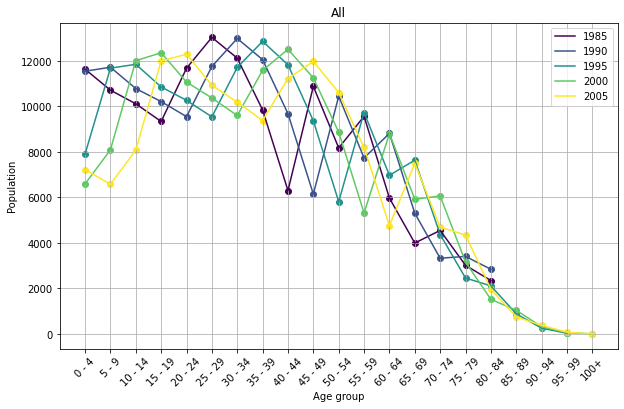

In [6]:
plotter([data], features=GROUPS, years=data["Year"].unique()[-5:], title="All")

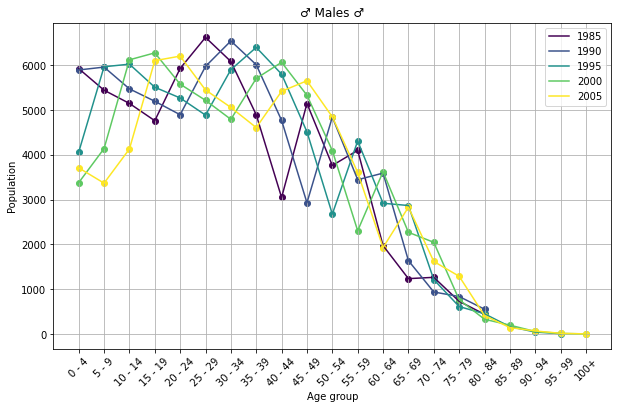

In [7]:
plotter([dataM], features=GROUPS, years=dataM["Year"].unique()[-5:], title="♂ Males ♂")

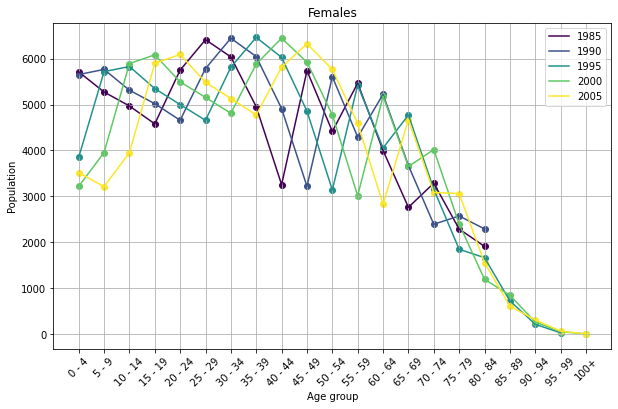

In [8]:
plotter([dataF], features=GROUPS, years=dataF["Year"].unique()[-5:], title="Females")

/tmp/ipykernel_32039/891739200.py:16: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.plot(X, Y, label=lbl, linestyle=styles[k], color=colors[it])


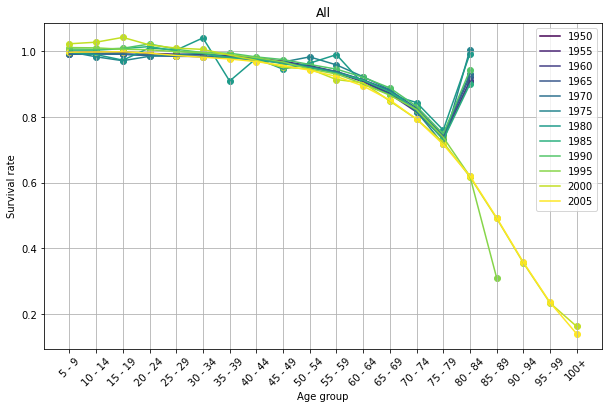

In [9]:
plotter([data], features=SR, years=data["Year"].unique(),
        remove="SR: ", title="All", ylabel="Survival rate")

/tmp/ipykernel_32039/891739200.py:16: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.plot(X, Y, label=lbl, linestyle=styles[k], color=colors[it])


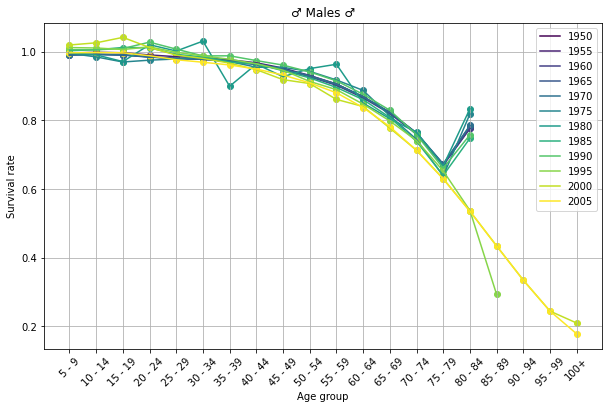

In [10]:
plotter([dataM], features=SR, years=data["Year"].unique(),
        remove="SR: ", title="♂ Males ♂", ylabel="Survival rate")

/tmp/ipykernel_32039/891739200.py:16: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.plot(X, Y, label=lbl, linestyle=styles[k], color=colors[it])


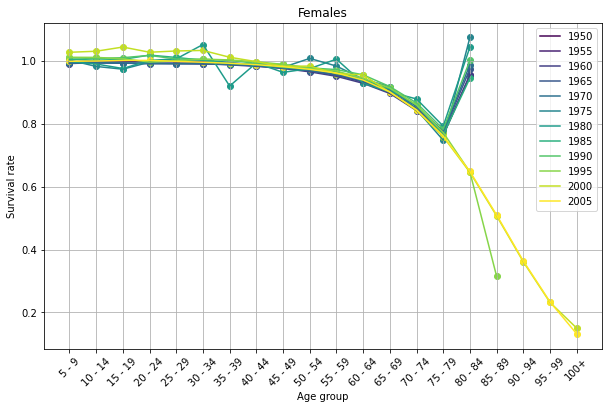

In [11]:
plotter([dataF], features=SR, years=data["Year"].unique(),
        remove="SR: ", title="Females", ylabel="Survival rate")

## Modelling

In [12]:
def Model(dataF, dataM, n1=4, n2=8, k_max=9, gamma1=1, gamma2=1):
    """
        ⠀⠀⠀⠀⠀⠀⠀ ⣠⣤⣤⣤⣤⣤⣶⣦⣤⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀
    ⠀⠀⠀⠀⠀⠀⠀⠀⢀⣴⣿⡿⠛⠉⠙⠛⠛⠛⠛⠻⢿⣿⣷⣤⡀⠀⠀⠀⠀⠀
    ⠀⠀⠀⠀⠀⠀⠀⠀⣼⣿⠋⠀⠀⠀⠀⠀⠀⠀⢀⣀⣀⠈⢻⣿⣿⡄⠀⠀⠀⠀
    ⠀⠀⠀⠀⠀⠀⠀⣸⣿⡏⠀⠀⠀⣠⣶⣾⣿⣿⣿⠿⠿⠿⢿⣿⣿⣿⣄⠀⠀⠀
    ⠀⠀⠀⠀⠀⠀⠀⣿⣿⠁⠀⠀⢰⣿⣿⣯⠁⠀⠀⠀⠀⠀⠀⠀⠈⠙⢿⣷⡄⠀
    ⠀⠀⣀⣤⣴⣶⣶⣿⡟⠀⠀⠀⢸⣿⣿⣿⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣷⠀
    ⠀⢰⣿⡟⠋⠉⣹⣿⡇⠀⠀⠀⠘⣿⣿⣿⣿⣷⣦⣤⣤⣤⣶⣶⣶⣶⣿⣿⣿⠀
    ⠀⢸⣿⡇⠀⠀⣿⣿⡇⠀⠀⠀⠀⠹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠃⠀
    ⠀⣸⣿⡇⠀⠀⣿⣿⡇⠀⠀⠀⠀⠀⠉⠻⠿⣿⣿⣿⣿⡿⠿⠿⠛⢻⣿⡇⠀⠀
    ⠀⣿⣿⠁⠀⠀⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣧⠀⠀
    ⠀⣿⣿⠀⠀⠀⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⠀⠀
    ⠀⣿⣿⠀⠀⠀⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⠀⠀
    ⠀⢿⣿⡆⠀⠀⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⡇⠀⠀
    ⠀⠸⣿⣧⡀⠀⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠃⠀⠀
    ⠀⠀⠛⢿⣿⣿⣿⣿⣇⠀⠀⠀⠀⠀⣰⣿⣿⣷⣶⣶⣶⣶⠶⠀⢠⣿⣿⠀⠀⠀
    ⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⣿⣿⡇⠀⣽⣿⡏⠁⠀⠀⢸⣿⡇⠀⠀⠀
    ⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⣿⣿⡇⠀⢹⣿⡆⠀⠀⠀⣸⣿⠇⠀⠀⠀
    ⠀⠀⠀⠀⠀⠀⠀⢿⣿⣦⣄⣀⣠⣴⣿⣿⠁⠀⠈⠻⣿⣿⣿⣿⡿⠏⠀⠀⠀⠀
    ⠀⠀⠀⠀⠀⠀⠀⠈⠛⠻⠿⠿⠿⠿⠋⠁⠀⠀⠀⠀⠀⠀⠀
    """
    
    sr_m = dataM[dataM["Year"]==2005][SR].mean(axis=0).values
    sr_f = dataF[dataF["Year"]==2005][SR].mean(axis=0).values
    
    df_prof_m = [dataM[dataM["Year"]==2005][GROUPS].values.reshape(-1)]
    df_prof_f = [dataF[dataF["Year"]==2005][GROUPS].values.reshape(-1)]
    
    fert_rate = dataF[-3:]["FR"].mean()
    mf_ratio = (dataM[dataM["Year"]==2005][GROUPS[0]] \
                / dataF[dataF["Year"]==2005][GROUPS[0]]).values[0]
    
    years = [2005]
    
    for k in range(k_max):
        prof_m, prof_f = np.zeros(len(GROUPS)), np.zeros(len(GROUPS))
        prof_f[1:] = gamma2 * sr_f * df_prof_f[-1][:-1]
        prof_m[1:] = gamma2 * sr_m * df_prof_m[-1][:-1]
        prof_f[0] = gamma1**k * fert_rate * (prof_f[n1:n2]).sum()
        prof_m[0] = gamma1**k * fert_rate * (prof_f[n1:n2]).sum() * mf_ratio
        
        df_prof_m.append(prof_m)
        df_prof_f.append(prof_f)
        years.append(years[-1] + 5)
    
    prof = [df_prof_m[k] + df_prof_f[k] for k in range(len(years))]
    pred = pd.DataFrame()
    pred["Year"] = years[1:]
    pred[GROUPS] = np.array(prof[1:])
    
    pred_m = pd.DataFrame()
    pred_m["Year"] = years[1:]
    pred_m[GROUPS] = np.array(df_prof_m[1:])
    
    pred_f = pd.DataFrame()
    pred_f["Year"] = years[1:]
    pred_f[GROUPS] = np.array(df_prof_f[1:])
    
    return pred, pred_m, pred_f

In [13]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

def Evaluate(data, data_pred):
    MAE = mae(
        data[GROUPS].values.T,
        data_pred[GROUPS].values.T,
        multioutput="raw_values"
    )
    RMSE = mse(
        data[GROUPS].values.T,
        data_pred[GROUPS].values.T,
        squared=False,
        multioutput="raw_values"
    )
    R2 = r2(
        data[GROUPS].values.T,
        data_pred[GROUPS].values.T,
        multioutput="raw_values"
    )
    
    df = pd.DataFrame()
    df["Year"] = data["Year"]
    df["Orig_Est"] = data[GROUPS].sum(axis=1).apply(int)
    df["Pred"] = data_pred[GROUPS].sum(axis=1).apply(int)
    df["MAE"] = np.round(MAE, 0).astype("int")
    df["RMSE"] = np.round(RMSE, 0).astype("int")
    df["R2"] = np.round(R2, 3)
    return df

In [14]:
n1 = 4
n2 = 8

dataM["FR"] = dataM[GROUPS[0]] / dataM[GROUPS[n1:n2]].sum(axis=1)
dataF["FR"] = dataF[GROUPS[0]] / dataF[GROUPS[n1:n2]].sum(axis=1)
data_pred, data_pred_M, data_pred_F = Model(dataF, dataM, n1=n1, n2=n2)

## Comparison

### Both

In [15]:
data2 = pd.read_excel("age_data_2005.xlsx", sheet_name="both; 2010-50, medium-fertility")
data2 = data2[data2["Region"]=="Russian Federation"].replace(
    "-",
    np.nan
).reset_index(drop=True)
YEARS2 = np.sort(data2["Year"].unique())
data2.loc[data2["Year"].isin(
    YEARS2[1:]
), SR] = data2[data2["Year"].isin(
    YEARS2[1:]
)][GROUPS[1:]].values / data2[data2["Year"].isin(
    YEARS2[:-1]
)][GROUPS[:-1]].values
data2["FR"] = data2[GROUPS[0]] / data2[GROUPS[n1:n2]].sum(axis=1)

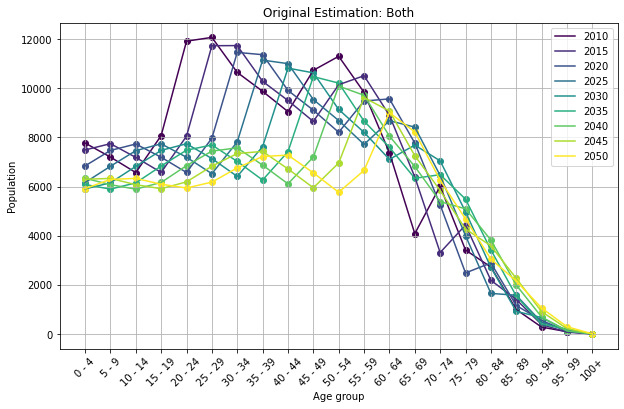

In [16]:
plotter(
    [data2],
    features=GROUPS,
    years=data2["Year"].unique(),
    title="Original Estimation: Both"
)

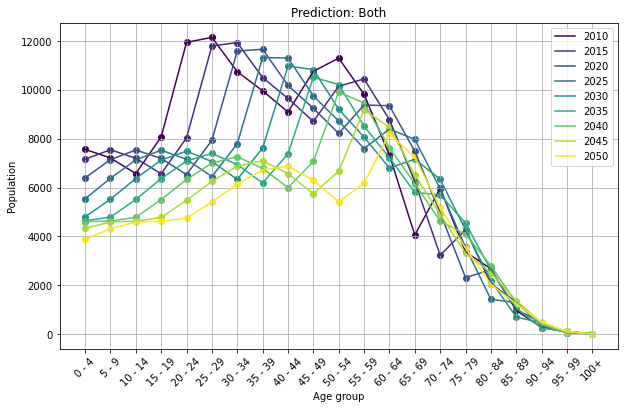

In [17]:
plotter(
    [data_pred],
    features=GROUPS,
    years=data_pred['Year'].unique(),
    title="Prediction: Both"
)

In [18]:
Evaluate(data2, data_pred)

,Year,Orig_Est,Pred,MAE,RMSE,R2
0,2010,140028,139888,40,61,1.000
1,2015,136682,135993,99,131,0.999
2,2020,133089,131285,165,206,0.997
3,2025,129214,125718,235,294,0.992
4,2030,125299,119388,322,428,0.982
5,2035,121653,112865,423,579,0.962
6,2040,118299,106366,570,734,0.930
7,2045,115071,99827,727,891,0.883
8,2050,111711,93224,882,1042,0.821


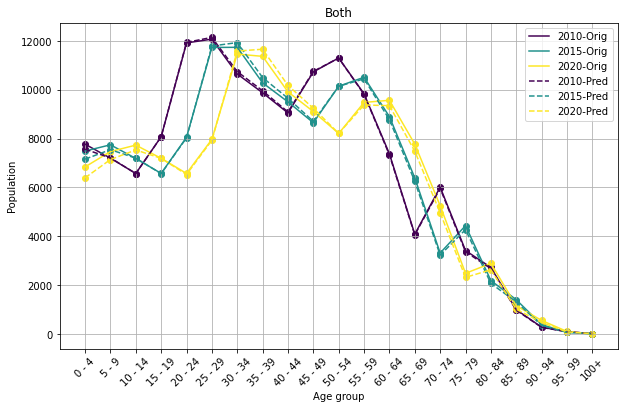

In [19]:
plotter(
    [data2, data_pred],
    features=GROUPS,
    years=data_pred["Year"].unique()[:3],
    prefixes=["Orig", "Pred"],
    styles=["-", "--"],
    title="Both"
)

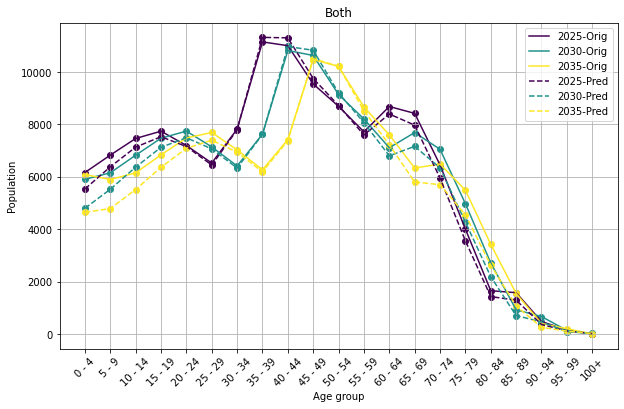

In [20]:
plotter(
    [data2, data_pred],
    features=GROUPS,
    years=data_pred["Year"].unique()[3:6],
    prefixes=["Orig", "Pred"],
    styles=["-", "--"],
    title="Both"
)

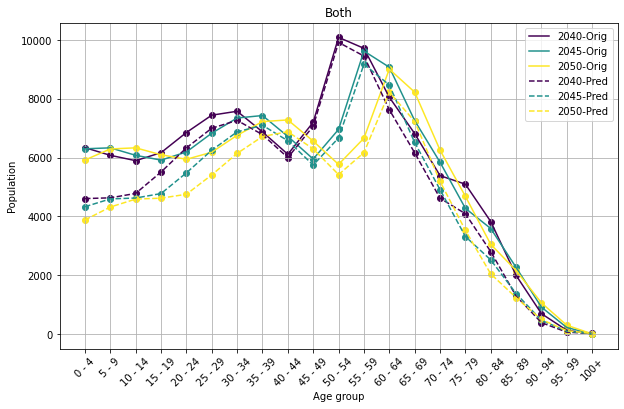

In [21]:
plotter(
    [data2, data_pred],
    features=GROUPS,
    years=data_pred["Year"].unique()[6:9],
    prefixes=["Orig", "Pred"],
    styles=["-", "--"],
    title="Both"
)

### Males

In [22]:
data2 = pd.read_excel("age_data_2005.xlsx", sheet_name="m; 2010-50, medium-fertility")
data2 = data2[data2["Region"]=="Russian Federation"].replace(
    "-",
    np.nan
).reset_index(drop=True)

YEARS2 = np.sort(data2["Year"].unique())
data2.loc[data2["Year"].isin(
    YEARS2[1:]
), SR] = data2[data2["Year"].isin(
    YEARS2[1:]
)][GROUPS[1:]].values / data2[data2["Year"].isin(
    YEARS2[:-1]
)][GROUPS[:-1]].values

data2['FR'] = data2[GROUPS[0]] / data2[GROUPS[n1:n2]].sum(axis=1)

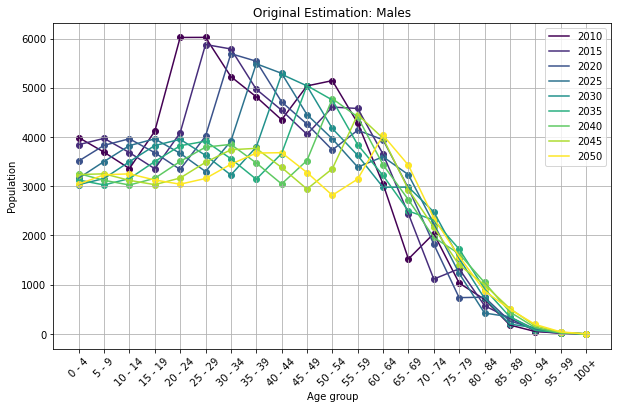

In [23]:
plotter(
    [data2],
    features=GROUPS,
    years=data2["Year"].unique(),
    title="Original Estimation: Males"
)

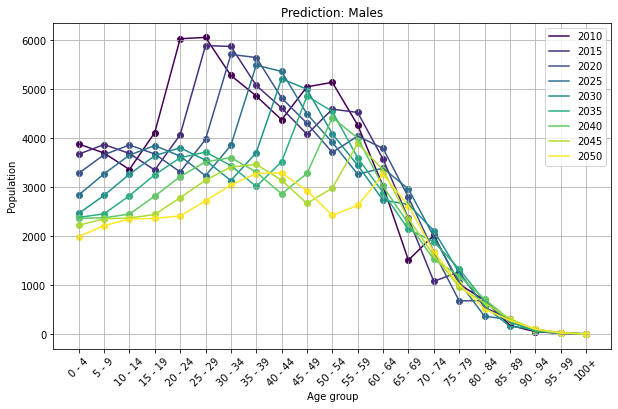

In [24]:
plotter(
    [data_pred_M],
    features=GROUPS,
    years=data_pred_M["Year"].unique(),
    title="Prediction: Males"
)

In [25]:
Evaluate(data2, data_pred_M)

,Year,Orig_Est,Pred,MAE,RMSE,R2
0,2010,64659,64625,19,31,1.000
1,2015,62864,62512,46,64,0.999
2,2020,61030,59987,76,100,0.997
3,2025,59125,57034,110,146,0.993
4,2030,57280,53742,169,221,0.981
5,2035,55674,50454,249,307,0.959
6,2040,54332,47301,335,400,0.923
7,2045,53130,44214,425,498,0.868
8,2050,51897,41138,513,592,0.794


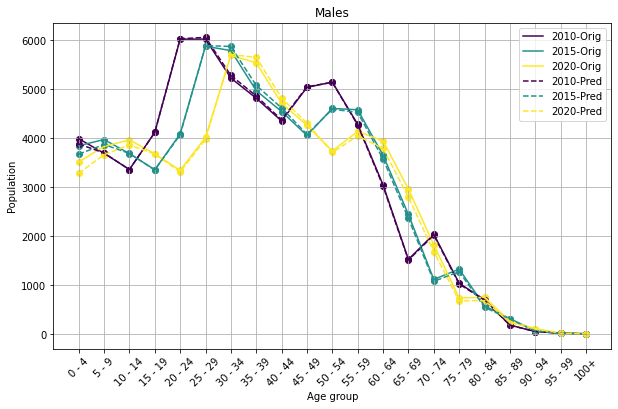

In [26]:
plotter(
    [data2, data_pred_M],
    features=GROUPS,
    years=data_pred_M["Year"].unique()[:3],
    prefixes=["Orig", "Pred"],
    styles=["-", "--"],
    title="Males"
)

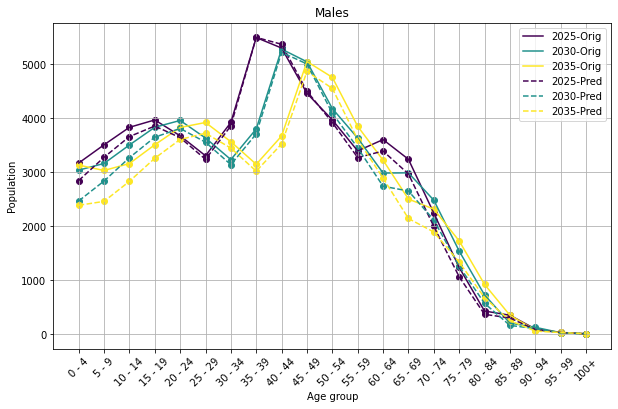

In [27]:
plotter(
    [data2, data_pred_M],
    features=GROUPS,
    years=data_pred_M["Year"].unique()[3:6],
    prefixes=["Orig", "Pred"],
    styles=["-", "--"],
    title="Males"
)

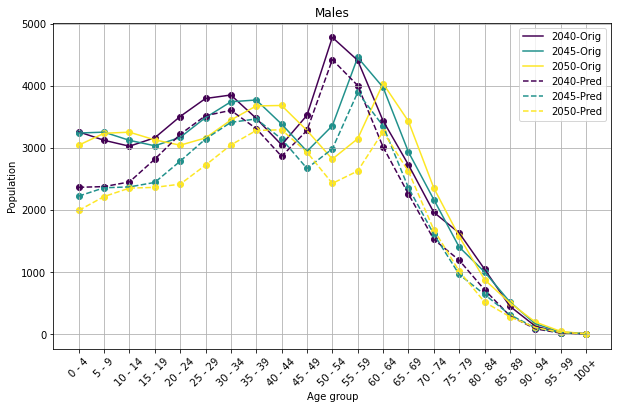

In [28]:
plotter(
    [data2, data_pred_M],
    features=GROUPS,
    years=data_pred_M["Year"].unique()[6:9],
    prefixes=["Orig", "Pred"],
    styles=["-", "--"],
    title="Males"
)

### Females

In [29]:
data2 = pd.read_excel("age_data_2005.xlsx", sheet_name="f; 2010-50, medium-fertility")
data2 = data2[data2["Region"]=="Russian Federation"].replace(
    "-",
    np.nan
).reset_index(drop=True)
YEARS2 = np.sort(data2["Year"].unique())
data2.loc[data2["Year"].isin(
    YEARS2[1:]
), SR] = data2[data2["Year"].isin(
    YEARS2[1:]
)][GROUPS[1:]].values / data2[data2["Year"].isin(
    YEARS2[:-1]
)][GROUPS[:-1]].values
data2["FR"] = data2[GROUPS[0]] / data2[GROUPS[n1:n2]].sum(axis=1)

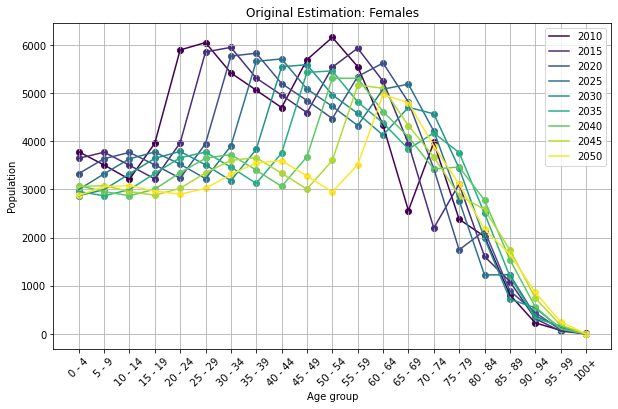

In [30]:
plotter(
    [data2],
    features=GROUPS,
    years=data2["Year"].unique(),
    title="Original Estimation: Females"
)

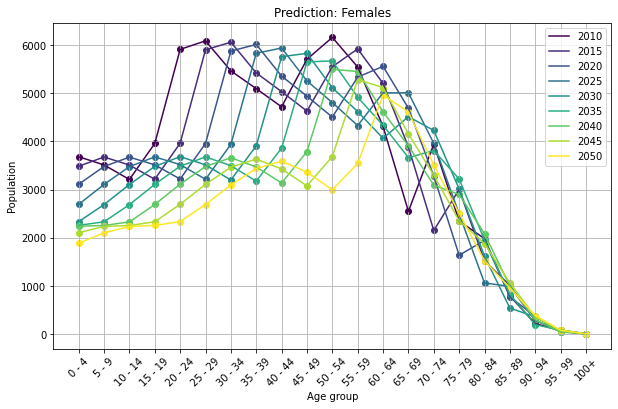

In [31]:
plotter(
    [data_pred_F],
    features=GROUPS,
    years=data_pred_F["Year"].unique(),
    title="Prediction: Females"
)

In [32]:
Evaluate(data2, data_pred_F)

,Year,Orig_Est,Pred,MAE,RMSE,R2
0,2010,75368,75263,21,31,1.000
1,2015,73818,73481,54,70,0.999
2,2020,72059,71297,92,114,0.996
3,2025,70088,68683,133,163,0.991
4,2030,68019,65646,184,232,0.980
5,2035,65979,62411,239,309,0.959
6,2040,63966,59064,290,382,0.927
7,2045,61941,55612,338,446,0.885
8,2050,59813,52086,384,502,0.836


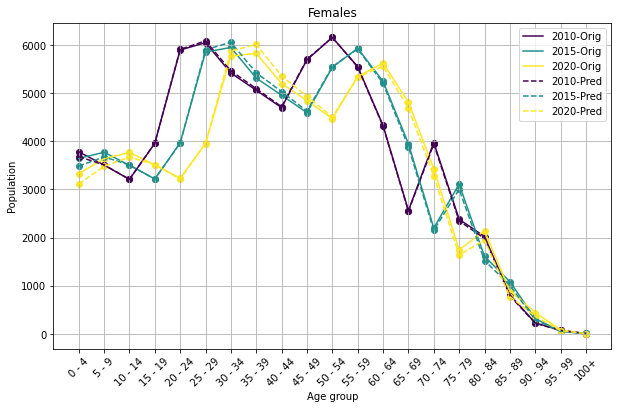

In [33]:
plotter(
    [data2, data_pred_F],
    features=GROUPS,
    years=data_pred_F["Year"].unique()[:3],
    prefixes=["Orig", "Pred"],
    styles=["-", "--"],
    title="Females"
)

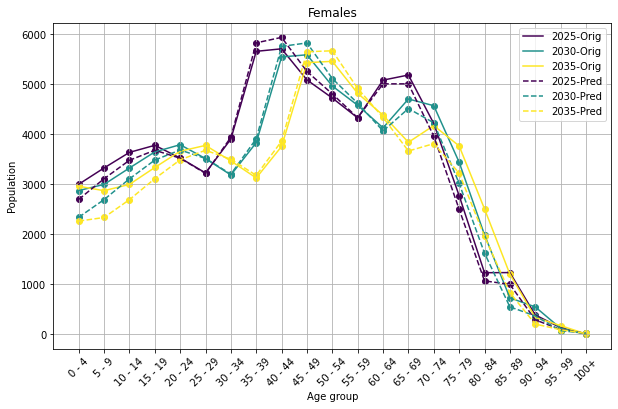

In [34]:
plotter(
    [data2, data_pred_F],
    features=GROUPS,
    years=data_pred_F["Year"].unique()[3:6],
    prefixes=["Orig", "Pred"],
    styles=["-", "--"],
    title="Females"
)

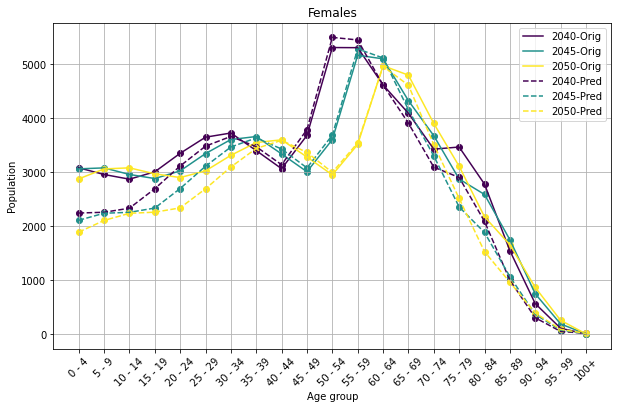

In [35]:
plotter(
    [data2, data_pred_F],
    features=GROUPS,
    years=data_pred_F["Year"].unique()[6:9],
    prefixes=["Orig", "Pred"],
    styles=["-", "--"],
    title="Females"
)